In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import style
import pickle
import colorsys
import csv
import algo as map
style.use('plotting.mplstyle')

/tmp/ipykernel_3131724/969254542.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2025-03-02 12:19:39.568570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-02 12:19:39.732321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot

# Figure 7: Correlation Paths for 90 Solar Mass Systems

This figure presents the **correlation paths** in the $[\eta, \chi_{\text{eff}}]$ space for binaries with a total mass of **90 $M_{\odot}$**, where both the inspiral and merger phases are observable. The blue lines represent the **effective spin mapping** in $[\eta, \chi_{\text{eff}}]$, while the dashed lines correspond to the **aligned spin mapping** projected from the 3D aligned space $[q, \chi_{1z}, \chi_{2z}]$.

- The color map shows the **mismatch $\mathcal{MM}$** between parameter points.
- The **correlation strength** is given in each panel as $r_{\text{eff}}$ and $r_{\text{al}}$, which correspond to the ratio of the semi-major to semi-minor axis of the **1-$\sigma$ contour**.


- The correlation paths are generally consistent, suggesting that $\chi_{\text{eff}}$ is still an appropriate aligned spin parameter at this total mass. However, the $r_{\text{eff}}$ are higher than the $r_{\text{al}}$, indicating that a more optimal spin-aligned parameter than $\chi_{\text{eff}}$ might exist

This is the plot we are generating in this notebook.

## Define calculated correlation strength

### Understanding $r$ Values 

The r values represent the square root of the ratio between the largest and smallest eigenvalues of the covariance matrix at the injection point. This quantifies the correlation strength of the mapped parameter space:
- The covariance matrix encodes the shape of the uncertainty ellipsoid.
- The condition number (largest eigenvalue / smallest eigenvalue) describes its elongation.
- $r = \sqrt{\lambda_{\max} / \lambda_{\min}}$ gives the aspect ratio of the $1-\sigma$ contour.

In Fig. 2 of the paper, the light blue ellipse represents this contour. This corresponds to Step 4 of the mapping algorithm in Sec. II C of the paper.

In [2]:
r_values_2d = [4.5, 9.0, 12.8]
r_values_3d = [12, 13, 9]

## Load in mapped paths

The files `mapped_paths_2D.csv` and `mapped_paths_3D.csv` contain the mapped degeneracy paths generated from the mapper. These paths represent the 
correlation structure in the $\chi_{\text{eff}}-\eta$ parameter space 
- `df_2d` stores the mapped paths for the 2D effective space $[\eta,\chi_{\text{eff}}]$.
- `df_3d` stores the mapped paths for the 3D aligned space $[q, \chi_{1z}, \chi_{2z}]$.
These precomputed paths will be used for comparison with each other and the newly generated background points.

In [3]:
df_2d = pd.read_csv("mapped_paths_2D.csv")
df_3d = pd.read_csv("mapped_paths_3D.csv")

## Generate background points

This section initializes the background points for the plot by defining the 
reference points in parameter space and generating samples for mapping. 

- The model is loaded using `map.load_and_update_model('90')`, corresponding to 
  a 90 solar mass network.
- Three reference points in parameter space are defined in `lams`, where each list 
  represents a different choice of initial parameters (for the three panels we are plotting)
- The loop iterates through each reference point, generating background points 
  using `map.ParameterSpace` with 10,000 samples and `precession = False` 
  (aligned spin degrees of freedom only).
- These background points are stored in `PS` and will be used for visualization.

In [4]:
PS = []
# load model corresponding to the desired network, 90 solar mass for this plot
map.load_and_update_model('90')
# define the three reference points from which we predict the misamtch of the parameter space
lams = [[0.16, 0.0, 0, -0.5, 0.0, 0, -0.5],[0.1875, 0, 0, 0, 0, 0, 0],[0.24, 0, 0, 0.5, 0, 0, 0.5]]
for lam0 in lams:
    # only aligned degrees of freedom
    ps = map.ParameterSpace(lam0 = lam0,  sample=10000, precession = False)
    # these are the background points for the plot
    PS.append(ps)

2025-03-02 12:19:42.694239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-02 12:19:42.694293: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-02 12:19:42.694313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev5): /proc/driver/nvidia/version does not exist
2025-03-02 12:19:42.694543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 9999/9999 [00:00<00:00, 15220.51it/s]


313/313 [==============================] - 1s 1ms/step


100%|██████████| 9999/9999 [00:00<00:00, 20531.29it/s]


313/313 [==============================] - 0s 1ms/step


100%|██████████| 9999/9999 [00:00<00:00, 14588.84it/s]


313/313 [==============================] - 0s 1ms/step


In [5]:
def fig7(name):
    fig = plt.figure(figsize=(19, 6))  
    gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1,0.04,  0.07],  wspace=0, hspace=0)
    
    axes = []
    for col in range(3):
        ax = fig.add_subplot(gs[0, col])
        axes.append(ax)

        if col > 0:
            ax.yaxis.set_visible(False)

    norm = Normalize(vmin=0, vmax=1)
    plot_indices = [0,4,8]
    for idx, (i, ax) in enumerate(zip(plot_indices, axes)):
        
        #Add background points
        ax.scatter(PS[idx].eta, PS[idx].chi_eff, c=PS[idx].mismatch, cmap='pink',rasterized = True)

        #Add 2D points
        eta_vals = df_2d[f"eta_{i}"]
        chi_eff_vals = df_2d[f"chi_eff_{i}"]
       
        ax.plot(eta_vals, chi_eff_vals, color='lightskyblue', alpha = 0.9,linestyle='-', lw=4, zorder=100, label ='$\mathbf{x^{(\mathrm{eff})}}$')
        
        ax.plot(PS[idx].eta[0], PS[idx].chi_eff[0], '*', markersize=35, markerfacecolor='black',
                markeredgecolor='lightskyblue', markeredgewidth=1.5, zorder =150)

        # Add 3D points
        eta_vals = df_3d[f"eta_{i}"]
        chi_eff_vals = df_3d[f"chi_eff_{i}"]
        ax.plot(eta_vals, chi_eff_vals, color='lightskyblue', linestyle='--', lw=4.5,zorder=100, label ='$\mathbf{x^{(\mathrm{al})}}$')
        

        ax.set_xlim(0.122, 0.25)
        ax.set_ylim(-0.9, 0.9)
        
        if i == 8:
            ax.legend(loc ="lower right", frameon = True, fontsize = 20)
        
        # Loop through and plot kappa annotations
        for idx, ax in enumerate(axes): 
            r_2d = r_values_2d[idx]
            r_3d = r_values_3d[idx]

            # Add annotation to each panel
            ax.annotate(
               rf'$r_\mathrm{{(eff)}}={r_2d}$' + '\n' + rf'$r_\mathrm{{(al)}}={r_3d}$',
                xy=(0.1, 0.85), 
                xycoords='axes fraction', 
                fontsize=20, 
                fontweight='bold', 
                bbox=dict(boxstyle="square,pad=0.5", edgecolor="k", linestyle='--', facecolor="white")
            )

    # Set y-ticks for the first subplot
    axes[0].set_yticks([-0.5, 0, 0.5])
    axes[0].tick_params(axis='y', labelsize=28)

    # Set x-ticks for the bottom subplots
    for ax in axes:
        ax.set_xticks([0.13, 0.17, 0.21])
        ax.tick_params(axis='x', labelsize=28)
        
  

    # Add labels for axes
    fig.text(0.5, -0.01, '$\eta$', ha='center', fontsize=36)
    fig.text(-0.01, 0.5, '$\chi_{\mathrm{eff}}$', va='center', rotation='vertical', fontsize=36)

    # Add the collective colorbar to the right
    cbar_ax = fig.add_subplot(gs[:, 4])
    sm = ScalarMappable(cmap='pink',norm = norm)
    sm.set_array([])  # Empty array for colormap reference
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('$\mathcal{MM}$', size=32)
    cbar.ax.tick_params(labelsize=22)
  
    plt.tight_layout()
    plt.savefig(name + '.png', bbox_inches='tight', pad_inches=0.5)

/tmp/ipykernel_3131724/2383033478.py:75: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sm, cax=cbar_ax)


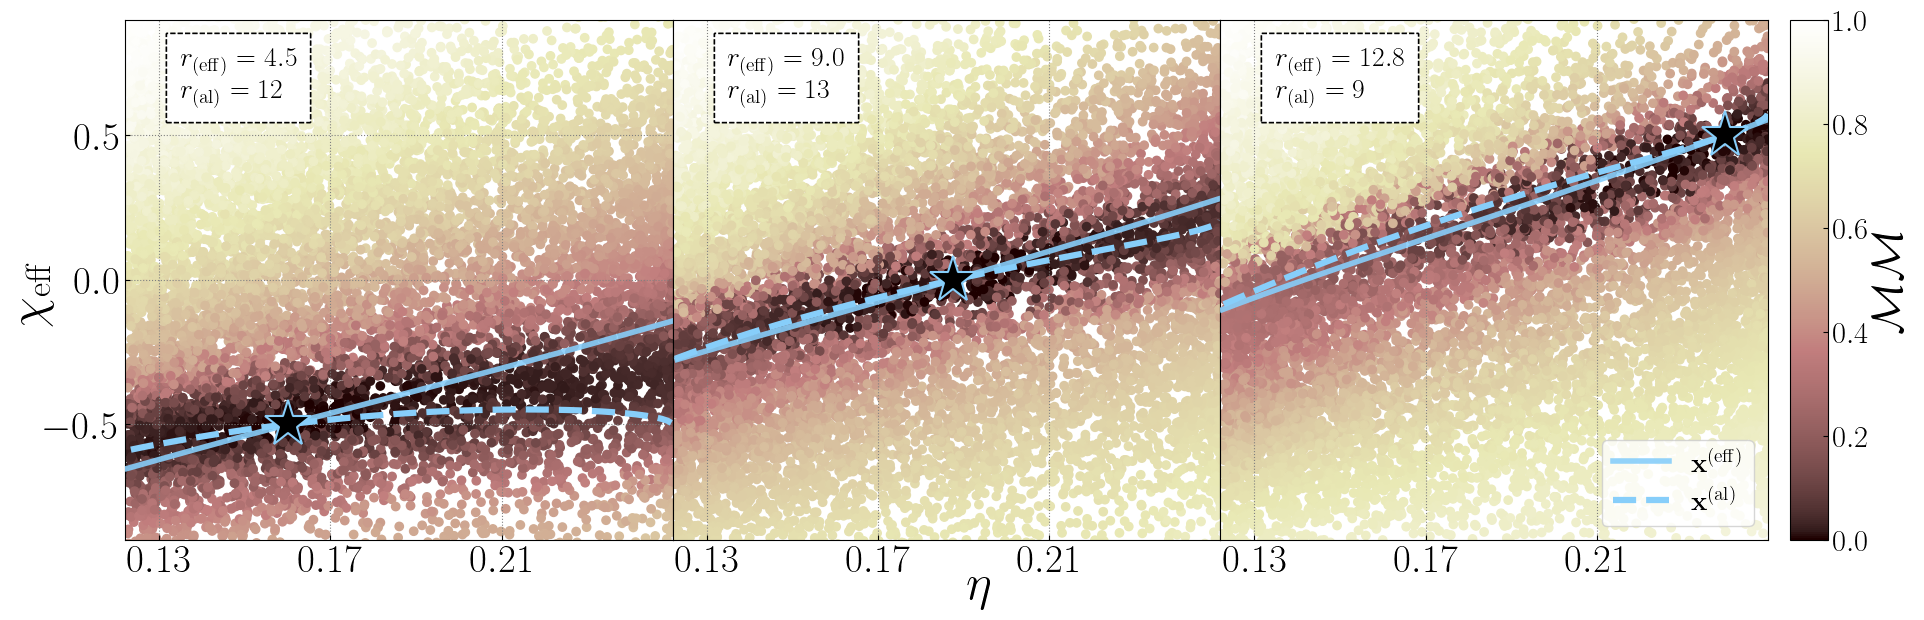

In [6]:
fig7('90_2D_3D')